In [1]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
from lib import GCNN_RN_randomLearn_2omics, GCNN_RN2, graph, coarsening, NN_randomLean1
import sys
import numpy as np
import math
import random
import scipy
from scipy import sparse
from optparse import OptionParser
import sklearn

In [14]:
# Read parkinson_data
import pandas as pd
# ppi_graph = pd.read_csv("/Users/wz/Dropbox/PhDThesis/COPDgraphCNN/COPDGene_SOMA_adjacency_diag0_uniGene.txt", sep='\t')

# ppi_graph = pd.read_csv("../COPDgraphCNN/partialCorr_ppi_minBIC_003.txt", sep='\t')

#part of String PPI
#ppi_graph = pd.read_csv("ppi_graph_1183.txt", sep='\t')
#ppi_graph = pd.read_csv("aggppi_graph_1183_2omicss_BIC_root.txt", sep='\t')
#ppi_graph = pd.read_csv("ppi_graph_1183_mRNA_updated_root.txt", sep='\t')
ppi_graph = pd.read_csv("ppi_graph_1183_mRNA_updated_root_2656sub.txt",  sep='\t')

In [15]:
ppi_graph.head()

,A2M,ABL1,ABL2,ACAN,ACE2,ACP1,ACP5,ACVR1B,ACVRL1,ACY1,...,XCL1,XPNPEP1,XRCC6,YES1,YWHAB,YWHAE,YWHAQ,YWHAZ,ZAP70,ZNRF3
A2M,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
ABL1,0.0,0.000000,0.652435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.755424,0.752384,0.746817,0.775231,0.757429,0.0,0.0
ABL2,0.0,0.652435,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
ACAN,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
ACE2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [18]:
ppi_graph.shape

(1183, 1183)

In [21]:
# Read parkinson_data
somalogic = pd.read_csv("somalogic_614sub_1183.txt", sep='\t')
# cols = list(somalogic.columns)
# cols = [cols[-1]] + cols[:-1]
# somalogic = somalogic[cols]
somalogic.head()

,A2M,ABL1,ABL2,ACAN,ACE2,ACP1,ACP5,ACVR1B,ACVRL1,ACY1,...,XCL1,XPNPEP1,XRCC6,YES1,YWHAB,YWHAE,YWHAQ,YWHAZ,ZAP70,ZNRF3
10010J,7346.1,144.0,2900.0,198.5,1548.5,754.0,4309.4,305.0,930.7,2450.7,...,277.7,364.6,142.4,484.9,9059.7,243.6,1266.1,57215.0,4263.8,373.2
10052Z,6673.2,189.5,3325.2,245.9,1463.4,1105.2,6171.1,134.1,1143.4,2206.5,...,313.4,467.4,228.0,597.4,19615.1,373.7,1314.4,144895.8,10528.9,399.9
10055F,11428.3,145.3,2149.7,391.9,1202.9,578.5,5964.7,179.2,1052.1,4936.2,...,374.7,1230.3,263.5,804.0,3886.9,817.1,1073.0,19969.3,16890.6,518.9
10060Y,10655.0,125.3,2179.4,240.9,1301.5,655.3,7355.1,167.0,971.2,4313.2,...,252.9,654.8,155.2,540.6,5991.7,584.7,1163.9,34231.4,9525.1,467.6
10086Q,7944.0,151.1,2487.8,180.7,1458.6,3625.6,5948.4,226.9,1303.1,3301.8,...,336.9,637.3,213.1,628.7,7731.4,322.0,1160.3,45732.8,11783.4,447.3


In [22]:
somalogic.min().min()

32.2

In [23]:
# Read parkinson_data
somalogic_sid = pd.read_csv("somalogic_614sub_1183_sid.txt", sep='\t')
# cols = list(somalogic.columns)
# cols = [cols[-1]] + cols[:-1]
# somalogic = somalogic[cols]
somalogic_sid.head()

,A2M,ABL1,ABL2,ACAN,ACE2,ACP1,ACP5,ACVR1B,ACVRL1,ACY1,...,XPNPEP1,XRCC6,YES1,YWHAB,YWHAE,YWHAQ,YWHAZ,ZAP70,ZNRF3,sid
10010J,7346.1,144.0,2900.0,198.5,1548.5,754.0,4309.4,305.0,930.7,2450.7,...,364.6,142.4,484.9,9059.7,243.6,1266.1,57215.0,4263.8,373.2,10010J
10052Z,6673.2,189.5,3325.2,245.9,1463.4,1105.2,6171.1,134.1,1143.4,2206.5,...,467.4,228.0,597.4,19615.1,373.7,1314.4,144895.8,10528.9,399.9,10052Z
10055F,11428.3,145.3,2149.7,391.9,1202.9,578.5,5964.7,179.2,1052.1,4936.2,...,1230.3,263.5,804.0,3886.9,817.1,1073.0,19969.3,16890.6,518.9,10055F
10060Y,10655.0,125.3,2179.4,240.9,1301.5,655.3,7355.1,167.0,971.2,4313.2,...,654.8,155.2,540.6,5991.7,584.7,1163.9,34231.4,9525.1,467.6,10060Y
10086Q,7944.0,151.1,2487.8,180.7,1458.6,3625.6,5948.4,226.9,1303.1,3301.8,...,637.3,213.1,628.7,7731.4,322.0,1160.3,45732.8,11783.4,447.3,10086Q


In [ ]:
#clin = pd.read_csv("../PhenoFlat_Oct17.csv")
clin = pd.read_csv("mrnaPhenoLarge_phase2_614subjects_120921.csv")
clin.head()

In [28]:
merged_data = somalogic_sid.merge(clin, left_on='sid', right_on='sid', how='inner')

In [29]:
merged_data.shape

(614, 1197)

In [ ]:
merged_data.head()

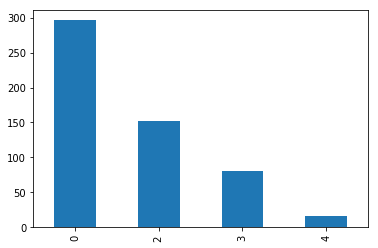

In [31]:
Goldfilter = merged_data.finalGold_P2 >=0
merged_data_revGold = merged_data[Goldfilter]
Goldfilter_2 = merged_data.finalGold_P2 != 1
merged_data_revGold = merged_data_revGold[Goldfilter_2]
merged_data_revGold["finalGold_P2"].value_counts().sort_index().plot(kind='bar')

In [32]:
merged_data_revGold['finalGold_P2_Bi'] = np.where(merged_data_revGold['finalGold_P2'] > 0.0, 1, 0)

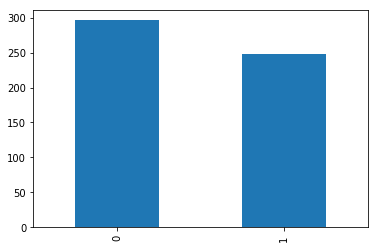

In [33]:
merged_data_revGold["finalGold_P2_Bi"].value_counts().sort_index().plot(kind='bar')

In [34]:
merged_data_revGold.shape

(544, 1198)

In [35]:
merged_revGold = pd.concat([merged_data_revGold.iloc[:,:1183], merged_data_revGold.iloc[:, merged_data_revGold.shape[1]-1]], axis=1)

In [36]:
merged_revGold.shape

(544, 1184)

In [ ]:
merged_revGold.head()

In [ ]:
# 
mRNA = pd.read_csv("mRNA_614sub_1183.txt", sep='\t')
#mRNA.set_index('sid', inplace=True)
mRNA.head()

In [ ]:
mRNA =  mRNA+ 0.00001
mRNA.head()

In [40]:
mRNA.loc["10934H", "BAD"]

71.00001

In [41]:
# soma_mRNA = merged_revGold
# soma_mRNA = soma_mRNA.drop(['finalGold_P2_Bi'], axis=1)
# for col in soma_mRNA.columns:
#     if col != "sid":
#         soma_mRNA[col].values[:] = 0
# soma_mRNA.set_index('sid', inplace=True)

In [ ]:
soma_mRNA = mRNA
soma_mRNA = soma_mRNA.loc[merged_data_revGold.sid]
soma_mRNA.head()

In [43]:
soma_mRNA.shape

(544, 1183)

In [44]:
len(merged_revGold.sum(axis=1))

544

In [45]:
print (min(merged_revGold.sum(axis=1)))
print (max(merged_revGold.sum(axis=1)))

5896255.0
12946796.4


In [ ]:
soma_mRNA_sid = soma_mRNA
# soma_mRNA_sid["sid"] = soma_mRNA.index
soma_mRNA_sid.reset_index

In [48]:
#Preparing the Data

# Extract feature columns
feature_cols = list(merged_revGold.columns[:-1])

target_col = merged_revGold.columns[-1]

# Show the list of columns
# print ("Feature columns:\n{}".format(feature_cols))
# print ("\nTarget column: {}".format(target_col))

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_soma_all = merged_revGold[feature_cols]
X_mRNA_all = soma_mRNA_sid[feature_cols]


In [49]:
len(feature_cols)

1183

In [50]:
finalGold_P2 = merged_data_revGold['finalGold_P2']

In [51]:
merged_data_revGold.shape

(544, 1198)

In [52]:
all_sid = merged_data_revGold['sid']

# log transformation

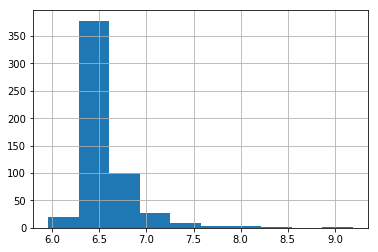

In [53]:
import matplotlib.pyplot as plt
X_soma_all["CD38"].apply(np.log).hist()
plt.show()

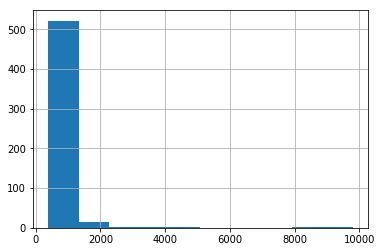

In [54]:

X_soma_all["CD38"].hist()
plt.show()

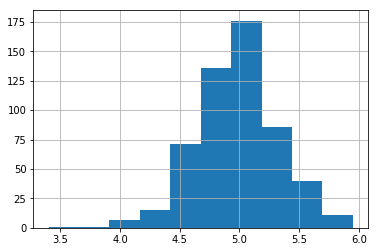

In [55]:
X_mRNA_all["CD38"].apply(np.log).hist()
plt.show()

In [56]:
X_soma_all = X_soma_all.apply(np.log)

In [57]:
X_mRNA_all = X_mRNA_all.apply(np.log)

In [58]:
# X_mRNA_all = (X_mRNA_all - X_mRNA_all.mean())/X_mRNA_all.std()

In [59]:
X_mRNA_all.std()[:5]

A2M     3.587825
ABL1    0.141701
ABL2    0.124182
ACAN    3.545921
ACE2    4.569507
dtype: float64

In [60]:
# X_soma_all = (X_soma_all - X_soma_all.mean())/X_soma_all.std()

In [61]:
X_soma_all.std()[:5]

A2M     0.265707
ABL1    0.333653
ABL2    0.260768
ACAN    0.362840
ACE2    0.371622
dtype: float64

# Standardize the features

In [62]:
from sklearn import preprocessing
# # Get column names first
names = X_mRNA_all.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
X_mRNA_all = scaler.fit_transform(X_mRNA_all)
X_mRNA_all = pd.DataFrame(X_mRNA_all, columns=names)
X_mRNA_all.std()[:5]

A2M     1.00092
ABL1    1.00092
ABL2    1.00092
ACAN    1.00092
ACE2    1.00092
dtype: float64

In [63]:
# Get column names first
names = X_soma_all.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
X_soma_all = scaler.fit_transform(X_soma_all)
X_soma_all = pd.DataFrame(X_soma_all, columns=names)

In [64]:
X_soma_all.std()[:5]

A2M     1.00092
ABL1    1.00092
ABL2    1.00092
ACAN    1.00092
ACE2    1.00092
dtype: float64

In [65]:
# X_soma_all.head


In [66]:
# X_mRNA_all.head

In [67]:
y_all = merged_revGold[target_col]

In [68]:
# standarization 

# X_all = X_all.div(X_all.sum(axis=1), axis=0)
# X_all = (X_all - X_all.mean())/X_all.std()*100

In [69]:
import numpy as np
# a = np.ones((3,4))
# b = np.ones((3,4))
# c = np.concatenate((a[...,np.newaxis],b[...,np.newaxis]),axis=2)
# print ("a:")
# print (a)
# print ("c:")
# print (c)

In [70]:
X_soma_all_array = np.array(X_soma_all)
X_mRNA_all_array = np.array(X_mRNA_all)

In [71]:
print (X_soma_all.shape)
print (X_mRNA_all.shape)

(544, 1183)
(544, 1183)


In [72]:
X_all = np.concatenate((X_soma_all_array[...,np.newaxis],X_mRNA_all_array[...,np.newaxis]),axis=2)

In [73]:
X_all.shape

(544, 1183, 2)

In [74]:
# Show the feature information by printing the first five rows
# print ("\nFeature values:")
print (X_all.shape)

(544, 1183, 2)


In [75]:
X_all[1:5, ]

array([[[-1.7412925 ,  0.27998505],
        [ 0.44854513,  0.33091599],
        [ 1.69477741, -0.02251661],
        ...,
        [ 2.25673444, -0.77907877],
        [-0.02248969, -1.08548708],
        [-0.50686604,  0.09143477]],

       [[ 0.28532992,  0.42249325],
        [-0.34818843, -0.82274638],
        [ 0.0204782 ,  0.74779024],
        ...,
        [-1.17444793,  0.67911257],
        [ 1.14800892, -0.10324669],
        [ 0.02442182,  0.09143477]],

       [[ 0.02140058,  0.27998505],
        [-0.79243983,  1.40593764],
        [ 0.07314556, -1.2958353 ],
        ...,
        [-0.24135235,  0.61544903],
        [-0.27062341, -0.27002033],
        [-0.18788792, -0.03868524]],

       [[-1.08463815,  0.47335666],
        [-0.23076922, -0.22238858],
        [ 0.58114956, -0.62160944],
        ...,
        [ 0.2601662 , -0.07375749],
        [ 0.25628996, -0.35608154],
        [-0.27840935, -0.40325312]]])

In [76]:
# Training and Testing Data Split

# Split the dataset in training (75%)  and testing (25%)
from sklearn.model_selection import train_test_split
X_train, X_valtest, y_train, y_valtest = train_test_split(X_all, y_all, test_size=0.40,random_state=2020)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5,random_state=2020)
print ("Shuffling of data into training, val and test sets complete!")

print ("Training set: {} samples".format(X_train.shape[0]))
print ("Val set: {} samples".format(X_val.shape[0]))
print ("Test set: {} samples".format(X_test.shape[0]))

Shuffling of data into training, val and test sets complete!
Training set: 326 samples
Val set: 109 samples
Test set: 109 samples


In [77]:
finalGold_train, finalGold_test = finalGold_P2[y_train.index], finalGold_P2[y_test.index]

In [78]:
test_sid = all_sid[y_test.index]

In [79]:
y_test.index

Int64Index([260,  33, 244, 440, 234, 425, 360, 382, 120, 161,
            ...
            386, 571, 122, 561, 345, 114, 217,  89, 484, 178],
           dtype='int64', length=109)

In [80]:
# X_train = X_train.values
# X_val = X_val.values
# X_test = X_test.values

In [81]:
# Concatenate data for conventional ML methods

X_train_2d = X_train.transpose(0, 2, 1).reshape(X_train.shape[0],-1)
X_val_2d = X_val.transpose(0, 2, 1).reshape(X_val.shape[0],-1)
X_test_2d = X_test.transpose(0, 2, 1).reshape(X_test.shape[0],-1)


In [82]:
#X_train_2d_new = X_train.transpose(0, 2, 1).reshape(X_train.shape[0],-1)

In [83]:
X_train[0:5, 0:5, 0]

array([[-9.13013476e-01, -1.12042928e-01,  9.41538507e-01,
        -8.30891431e-01, -4.77480858e-02],
       [ 6.23561252e-01, -8.04434565e-01, -1.18011827e+00,
        -5.97078257e-01,  5.54489216e-01],
       [ 1.68371097e-02, -3.19422235e-01,  1.95514859e-01,
        -7.44916056e-01,  3.12407055e-05],
       [-9.47742717e-01,  2.04772184e-02, -8.26353132e-01,
        -5.69539589e-03, -3.29886243e-02],
       [-1.01310184e+00,  9.08490032e-01, -3.75273580e-01,
         5.19853929e-01,  1.69653395e+00]])

In [84]:
X_train[0:5, 0:5, 1]

array([[-0.02650057, -0.38112778,  0.33877992,  2.91463892, -0.47118938],
       [ 0.51636108,  1.02171983, -0.25683774,  2.91463892, -0.47118938],
       [ 0.51636108, -0.4348436 ,  1.35409697, -0.33516041, -0.47118938],
       [ 0.36024148, -1.17307918,  1.54647076, -0.33516041,  2.05064333],
       [ 0.36024148, -0.32781736, -1.24192152, -0.33516041, -0.47118938]])

In [85]:
X_train_2d[0:5, 0:5]

array([[-9.13013476e-01, -1.12042928e-01,  9.41538507e-01,
        -8.30891431e-01, -4.77480858e-02],
       [ 6.23561252e-01, -8.04434565e-01, -1.18011827e+00,
        -5.97078257e-01,  5.54489216e-01],
       [ 1.68371097e-02, -3.19422235e-01,  1.95514859e-01,
        -7.44916056e-01,  3.12407055e-05],
       [-9.47742717e-01,  2.04772184e-02, -8.26353132e-01,
        -5.69539589e-03, -3.29886243e-02],
       [-1.01310184e+00,  9.08490032e-01, -3.75273580e-01,
         5.19853929e-01,  1.69653395e+00]])

In [86]:
X_train_2d[0:5, 1183:1187]

array([[-0.02650057, -0.38112778,  0.33877992,  2.91463892],
       [ 0.51636108,  1.02171983, -0.25683774,  2.91463892],
       [ 0.51636108, -0.4348436 ,  1.35409697, -0.33516041],
       [ 0.36024148, -1.17307918,  1.54647076, -0.33516041],
       [ 0.36024148, -0.32781736, -1.24192152, -0.33516041]])

In [87]:
X_train_pro = X_train_2d[:, :1183]
X_val_pro = X_val_2d[:, :1183]
X_test_pro = X_test_2d[:, :1183]
X_train_mRNA = X_train_2d[:, 1183:]
X_val_mRNA = X_val_2d[:, 1183:]
X_test_mRNA = X_test_2d[:, 1183:]

In [88]:
X_train_pro[1:5, 1:5]

array([[-8.04434565e-01, -1.18011827e+00, -5.97078257e-01,
         5.54489216e-01],
       [-3.19422235e-01,  1.95514859e-01, -7.44916056e-01,
         3.12407055e-05],
       [ 2.04772184e-02, -8.26353132e-01, -5.69539589e-03,
        -3.29886243e-02],
       [ 9.08490032e-01, -3.75273580e-01,  5.19853929e-01,
         1.69653395e+00]])

In [89]:
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

In [90]:
test_sid = test_sid.to_numpy()

In [92]:
print (X_train.shape)
print (y_train.shape)

(326, 1183, 2)
(326,)


In [93]:
# training sample
print ("Num of subjects: " + str(X_train.shape[0]))
print ("Num of nodes within subject: " + str(X_train.shape[1]))
print ("Num of features in each node within subject: " + str(X_train.shape[2]))

Num of subjects: 326
Num of nodes within subject: 1183
Num of features in each node within subject: 2



## Feature names updates for plotting

In [121]:
feature_name_pro = X_soma_all.columns +"_protein"
feature_name_mRNA = X_mRNA_all.columns +"_mRNA"
feature_name_conML = np.concatenate((feature_name_pro, feature_name_mRNA))

In [122]:
feature_name_conML

array(['A2M_protein', 'ABL1_protein', 'ABL2_protein', ..., 'YWHAZ_mRNA',
       'ZAP70_mRNA', 'ZNRF3_mRNA'], dtype=object)

In [157]:
samplegraph = ppi_graph.as_matrix()

/opt/conda/envs/myenv/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [158]:
numVertex = X_train.shape[1]

In [159]:
numVertex

1183

In [160]:
# convert regular adajency matrix to sparse matrix in COOrdinate format

data= []
row = []
col = []

for i in range(numVertex):
	for j in range(numVertex):
		if samplegraph[i,j] != 0.0:
			data.append(samplegraph[i,j])
			data.append(samplegraph[i,j])
			row.append(i)
			row.append(j)
			col.append(j)
			col.append(i)


In [161]:
ppi_graph.iloc[:1, 51:60]

,ANXA2,ANXA5,ANXA6,APCS,APOA1,APOB,APOD,APOL1,APOM
A2M,0.0,0.0,0.681401,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
A = sparse.coo_matrix((data, (row, col)), shape = (numVertex,numVertex))
A.setdiag(0)
# In case of the adajency is not symmetric, keep the bigger edge weight
bigger = A.T > A
A = A - A.multiply(bigger) + A.T.multiply(bigger)
A = A.astype(np.float32)

In [164]:
A.max()

1.8785647

In [167]:
A_degree = A.sum(axis=0) - A.diagonal()
A_degree

matrix([[ 81.66208 , 102.460945,  30.873003, ...,  89.905266,  98.256195,
          11.315005]], dtype=float32)

In [170]:
import pickle
# saved_objectlist = [graphs, perm, params]  
# pickle_out = open("gnn_saved_objectlist_122721_mRNA_2656_2.pickle", "wb")
# pickle.dump(saved_objectlist,pickle_out,protocol=2)
# pickle_out.close()

pickle_in = open("gnn_saved_objectlist_122721_mRNA_2656_2.pickle", "rb")
saved_objectlist = pickle.load(pickle_in)
graphs, perm, params = saved_objectlist[0], saved_objectlist[1], saved_objectlist[2]

In [171]:
#graphs, perm = coarsening.coarsen(A, levels=3, self_connections=False)

L = [graph.laplacian(A, normalized=True) for A in graphs]

In [172]:
def compute_perm(parents):
	"""
	Return a list of indices to reorder the adjacency and data matrices so
	that the union of two neighbors from layer to layer forms a binary tree.
	"""

	# Order of last layer is random (chosen by the clustering algorithm).
	indices = []
	if len(parents) > 0:
		M_last = max(parents[-1]) + 1
		indices.append(list(range(M_last)))

	for parent in parents[::-1]:
		#print('parent: {}'.format(parent))

		# Fake nodes go after real ones.
		pool_singeltons = len(parent)

		indices_layer = []
		for i in indices[-1]:
			indices_node = list(np.where(parent == i)[0])
			assert 0 <= len(indices_node) <= 2
			#print('indices_node: {}'.format(indices_node))

			# Add a node to go with a singelton.
			if len(indices_node) is 1:
				indices_node.append(pool_singeltons)
				pool_singeltons += 1
				#print('new singelton: {}'.format(indices_node))
			# Add two nodes as children of a singelton in the parent.
			elif len(indices_node) is 0:
				indices_node.append(pool_singeltons+0)
				indices_node.append(pool_singeltons+1)
				pool_singeltons += 2
				#print('singelton childrens: {}'.format(indices_node))

			indices_layer.extend(indices_node)
		indices.append(indices_layer)

	# Sanity checks.
	for i,indices_layer in enumerate(indices):
		M = M_last*2**i
		# Reduction by 2 at each layer (binary tree).
		assert len(indices[0] == M)
		# The new ordering does not omit an indice.
		assert sorted(indices_layer) == list(range(M))

	return indices[::-1]


In [189]:
def perm_2ddata(x, indices):
	"""
	Permute data matrix, i.e. exchange node ids,
	so that binary unions form the clustering tree.
	"""
	if indices is None:
		return x

	N, M, K = x.shape
	Mnew = len(indices)
	assert Mnew >= M
	xnew = np.empty((N, Mnew, K))
	for i,j in enumerate(indices):
		# Existing vertex, i.e. real data.
		if j < M:
			xnew[:, i, 0] = x[:, j, 0]
			xnew[:, i, 1] = x[:, j, 1]
		# Fake vertex because of singeltons.
		# They will stay 0 so that max pooling chooses the singelton.
		# Or -infty ?
		else:
			xnew[:, i, 0] = np.zeros(N)
			xnew[:, i, 1] = np.zeros(N)
	return xnew

In [190]:
X_train_gnn_1d = coarsening.perm_data(X_train[:,:,0], perm)

X_train_gnn_1d.shape

(326, 1208)

In [191]:
len(perm)

1208

In [192]:
X_train[:,:,0].shape

(326, 1183)

In [193]:
len(perm)

1208

In [194]:
X_train.shape

(326, 1183, 2)

In [195]:
X_train_gnn = perm_2ddata(X_train, perm)
X_val_gnn = perm_2ddata(X_val, perm)
X_test_gnn = perm_2ddata(X_test, perm)

In [197]:
X_train_gnn.shape

(326, 1208, 2)

In [198]:
params = dict()
params['dir_name']       = 'overlapping_1183_122721_reon_mRNA_log'
params['num_epochs']     = 50
params['batch_size']     = 100
params['eval_frequency'] = 10

# Building blocks.
params['filter']         = 'chebyshev'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'


In [199]:
# Number of classes.
C=2

# Architecture.
params['F']              = [32, 32]  # Number of graph convolutional filters.
params['K']              = [10, 2]  # Polynomial orders.
params['p']              = [2, 2]    # Pooling sizes.
params['M']              = [64, 64, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 0.8
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['decay_steps']    = 1000 / params['batch_size']

In [200]:
#RN
#params['edgeCut'] = 200
#params['edgeCut'] = 0

In [201]:
#RN
params['edgeCut'] = 0

In [202]:
# np.mod(2.3, 1)

In [203]:
# p_log2 = np.where(np.array([2, 2]) > 1, np.log2([2, 2]), 0)
# p_log2

In [204]:
# accuracies = map(lambda x: float(x), accuracy0)
# model = GCNN_RN_randomLearn.rngcnn(L, graphs[2], **params)

In [205]:
graphs[3]

<151x151 sparse matrix of type '<type 'numpy.float32'>'
	with 15208 stored elements in Compressed Sparse Row format>

# Single omics for GraphNN

## Proteomics

In [206]:
params = dict()
params['dir_name']       = 'overlapping_singleProteomics_1183_122721_py2_2_reon_mRNA_2656Shap_log'
params['num_epochs']     = 25
params['batch_size']     = 100
params['eval_frequency'] = 10

# Building blocks.
params['filter']         = 'chebyshev'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

In [207]:
# Number of classes.
C=2

# Architecture.
params['F']              = [32, 32]  # Number of graph convolutional filters.
params['K']              = [10, 2]  # Polynomial orders.
params['p']              = [2, 2]    # Pooling sizes.
params['M']              = [64, 64, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
#params['dropout']        = 0.8
params['dropout']        = 0.7
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['decay_steps']    = 1000 / params['batch_size']

In [208]:
#RN
#params['edgeCut'] = 200
params['edgeCut'] = 0

In [548]:
from lib import GCNN_RN_randomLearn, GCNN_RN2, graph, coarsening

accuracies = map(lambda x: float(x), accuracy0)
model = GCNN_RN_randomLearn.rngcnn(L, graphs[3], **params)

NN architecture
  input: M_0 = 1208
  layer 1: cgconv1
	representation: M_0 * F_1 / p_1 = 1208 * 32 / 2 = 19328
	weights: F_0 * F_1 * K_1 = 1 * 32 * 10 = 320
	biases: F_1 = 32
  layer 2: cgconv2
	representation: M_1 * F_2 / p_2 = 604 * 32 / 2 = 9664
	weights: F_1 * F_2 * K_2 = 32 * 32 * 2 = 2048
	biases: F_2 = 32
  layer 3: fc1
	representation: M_3 = 64
	weights: M_2 * M_3 = 9664 * 64 = 618496
	biases: M_3 = 64
  layer 4: fc2
	representation: M_4 = 64
	weights: M_3 * M_4 = 64 * 64 = 4096
	biases: M_4 = 64
  layer 5: logits (softmax)
	representation: M_5 = 2
	weights: M_4 * M_5 = 64 * 2 = 128
	biases: M_5 = 2


In [549]:
accuracy1, loss1, t_step1, f1s1 = model.fit(X_train_gnn[:, :, 0], y_train, X_val_gnn[:, :, 0], y_val)
accuracies.append(accuracy1[-1])

step 10 / 81 (epoch 3.00 / 25):
  learning_rate = 1.00e-03, loss_average = 9.76e-01
  validation accuracy: 55.96 (61 / 109), f1 (weighted): 47.21, loss: 1.05e+00
check point saved
step 20 / 81 (epoch 6.00 / 25):
  learning_rate = 9.50e-04, loss_average = 9.37e-01
  validation accuracy: 54.13 (59 / 109), f1 (weighted): 49.52, loss: 1.03e+00
step 30 / 81 (epoch 9.00 / 25):
  learning_rate = 9.03e-04, loss_average = 8.10e-01
  validation accuracy: 64.22 (70 / 109), f1 (weighted): 62.64, loss: 1.04e+00
check point saved
step 40 / 81 (epoch 12.00 / 25):
  learning_rate = 8.57e-04, loss_average = 6.81e-01
  validation accuracy: 65.14 (71 / 109), f1 (weighted): 64.59, loss: 1.07e+00
check point saved
step 50 / 81 (epoch 15.00 / 25):
  learning_rate = 8.15e-04, loss_average = 5.77e-01
  validation accuracy: 67.89 (74 / 109), f1 (weighted): 68.06, loss: 1.07e+00
check point saved
step 60 / 81 (epoch 18.00 / 25):
  learning_rate = 7.74e-04, loss_average = 4.76e-01
  validation accuracy: 67.89 (7

In [550]:
test_pred = model.predict(X_test_gnn[:, :, 0], shrinkage=np.repeat(1, 1))
test_accuracy_gnn = 100 * sklearn.metrics.accuracy_score(y_test, test_pred)
print ("test_accuyacy_gnn: {}".format(test_accuracy_gnn))

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/overlapping_singleProteomics_1183_122721_py2_2_reon_mRNA_2656Shap_log/model-81
test_accuyacy_gnn: 66.9724770642


## Genomics

In [554]:
params = dict()
params['dir_name']       = 'overlapping_mRNA_1183_122121_py2_reon_mRNA_2656_shap_log'
params['num_epochs']     = 25
params['batch_size']     = 100
params['eval_frequency'] = 10

# Building blocks.
params['filter']         = 'chebyshev'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

In [555]:
# Number of classes.
C=2

# Architecture.
params['F']              = [32, 32]  # Number of graph convolutional filters.
params['K']              = [10, 2]  # Polynomial orders.
params['p']              = [2, 2]    # Pooling sizes.
params['M']              = [64, 64, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
#params['dropout']        = 0.8
params['dropout']        = 0.7
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['decay_steps']    = 1000 / params['batch_size']

In [556]:
#RN
#params['edgeCut'] = 200
params['edgeCut'] = 0

In [557]:
from lib import GCNN_RN_randomLearn, GCNN_RN2, GCNN_RN2_rev, graph, coarsening

accuracies = map(lambda x: float(x), accuracy0)
model_mRNA = GCNN_RN_randomLearn.rngcnn(L, graphs[3], **params)

NN architecture
  input: M_0 = 1208
  layer 1: cgconv1
	representation: M_0 * F_1 / p_1 = 1208 * 32 / 2 = 19328
	weights: F_0 * F_1 * K_1 = 1 * 32 * 10 = 320
	biases: F_1 = 32
  layer 2: cgconv2
	representation: M_1 * F_2 / p_2 = 604 * 32 / 2 = 9664
	weights: F_1 * F_2 * K_2 = 32 * 32 * 2 = 2048
	biases: F_2 = 32
  layer 3: fc1
	representation: M_3 = 64
	weights: M_2 * M_3 = 9664 * 64 = 618496
	biases: M_3 = 64
  layer 4: fc2
	representation: M_4 = 64
	weights: M_3 * M_4 = 64 * 64 = 4096
	biases: M_4 = 64
  layer 5: logits (softmax)
	representation: M_5 = 2
	weights: M_4 * M_5 = 64 * 2 = 128
	biases: M_5 = 2


In [558]:
accuracy1, loss1, t_step1, f1s1 = model_mRNA.fit(X_train_gnn[:, :, 1], y_train, X_val_gnn[:, :, 1], y_val)
accuracies.append(accuracy1[-1])

step 10 / 81 (epoch 3.00 / 25):
  learning_rate = 1.00e-03, loss_average = 6.58e-01
  validation accuracy: 66.97 (73 / 109), f1 (weighted): 67.33, loss: 1.24e+00
check point saved
step 20 / 81 (epoch 6.00 / 25):
  learning_rate = 9.50e-04, loss_average = 6.06e-01
  validation accuracy: 66.97 (73 / 109), f1 (weighted): 66.58, loss: 1.36e+00
check point saved
step 30 / 81 (epoch 9.00 / 25):
  learning_rate = 9.03e-04, loss_average = 4.96e-01
  validation accuracy: 76.15 (83 / 109), f1 (weighted): 76.40, loss: 1.12e+00
check point saved
step 40 / 81 (epoch 12.00 / 25):
  learning_rate = 8.57e-04, loss_average = 3.79e-01
  validation accuracy: 82.57 (90 / 109), f1 (weighted): 81.96, loss: 9.61e-01
check point saved
step 50 / 81 (epoch 15.00 / 25):
  learning_rate = 8.15e-04, loss_average = 2.85e-01
  validation accuracy: 80.73 (88 / 109), f1 (weighted): 80.92, loss: 1.05e+00
step 60 / 81 (epoch 18.00 / 25):
  learning_rate = 7.74e-04, loss_average = 1.98e-01
  validation accuracy: 81.65 (8

In [559]:
test_pred = model_mRNA.predict(X_test_gnn[:, :, 1], shrinkage=np.repeat(1, 1))
test_accuracy_gnn = 100 * sklearn.metrics.accuracy_score(y_test, test_pred)
print ("test_accuyacy_gnn: {}".format(test_accuracy_gnn))

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/overlapping_mRNA_1183_122121_py2_reon_mRNA_2656_shap_log/model-40
test_accuyacy_gnn: 70.6422018349


# Two omics integration with shared filter in graph convolution

In [209]:
params = dict()
params['dir_name']       = 'TwoOmics_1183_122721_shared_reon_mRNA_2656_log'
params['num_epochs']     = 25
params['batch_size']     = 100
params['eval_frequency'] = 10

# Building blocks.
params['filter']         = 'chebyshev'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C=2

# Architecture.
params['F']              = [32, 32]  # Number of graph convolutional filters.
params['K']              = [10, 2]  # Polynomial orders.
params['p']              = [2, 2]    # Pooling sizes.
params['M']              = [64, 64, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
#params['dropout']        = 0.8
params['dropout']        = 0.7
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['decay_steps']    = 1000 / params['batch_size']

#RN
#params['edgeCut'] = 200
params['edgeCut'] = 0

In [210]:
from lib import GCNN_RN_randomLearn_15m
model_2omics = GCNN_RN_randomLearn_15m.rngcnn(L, graphs[3], **params)

NN architecture
  input: M_0 = 1208
  layer 1: cgconv1
	representation: M_0 * F_1 / p_1 = 1208 * 32 / 2 = 19328
	weights: F_0 * F_1 * K_1 = 1 * 32 * 10 = 320
	biases: F_1 = 32
  layer 2: cgconv2
	representation: M_1 * F_2 / p_2 = 604 * 32 / 2 = 9664
	weights: F_1 * F_2 * K_2 = 32 * 32 * 2 = 2048
	biases: F_2 = 32
  layer 3: fc1
	representation: M_3 = 64
	weights: M_2 * M_3 = 9664 * 64 = 618496
	biases: M_3 = 64
  layer 4: fc2
	representation: M_4 = 64
	weights: M_3 * M_4 = 64 * 64 = 4096
	biases: M_4 = 64
  layer 5: logits (softmax)
	representation: M_5 = 2
	weights: M_4 * M_5 = 64 * 2 = 128
	biases: M_5 = 2


In [562]:
accuracy1, loss1, t_step1, f1s1 = model_2omics.fit(X_train_gnn, y_train, X_val_gnn, y_val)

step 10 / 81 (epoch 3.00 / 25):
  learning_rate = 1.00e-03, loss_average = 1.06e+00
(100, 1208, 2)
(9, 1208, 2)
  validation accuracy: 66.97 (73 / 109), f1 (weighted): 64.58, loss: 1.10e+00
check point saved
step 20 / 81 (epoch 6.00 / 25):
  learning_rate = 9.50e-04, loss_average = 9.22e-01
(100, 1208, 2)
(9, 1208, 2)
  validation accuracy: 66.06 (72 / 109), f1 (weighted): 66.27, loss: 1.47e+00
step 30 / 81 (epoch 9.00 / 25):
  learning_rate = 9.03e-04, loss_average = 6.69e-01
(100, 1208, 2)
(9, 1208, 2)
  validation accuracy: 71.56 (78 / 109), f1 (weighted): 71.85, loss: 1.29e+00
check point saved
step 40 / 81 (epoch 12.00 / 25):
  learning_rate = 8.57e-04, loss_average = 4.42e-01
(100, 1208, 2)
(9, 1208, 2)
  validation accuracy: 78.90 (86 / 109), f1 (weighted): 79.01, loss: 1.24e+00
check point saved
step 50 / 81 (epoch 15.00 / 25):
  learning_rate = 8.15e-04, loss_average = 2.94e-01
(100, 1208, 2)
(9, 1208, 2)
  validation accuracy: 77.06 (84 / 109), f1 (weighted): 77.30, loss: 1.3

In [563]:
# train_pred = model_3omics.predict(X_train_gnn, shrinkage=[1])
# train_accuracy_gnn = 100 * sklearn.metrics.accuracy_score(y_train, train_pred)
# print ("train_accuyacy_gnn: {}".format(train_accuracy_gnn))

In [564]:
val_pred = model_2omics.predict(X_val_gnn, shrinkage=[1])
train_accuracy_gnn = 100 * sklearn.metrics.accuracy_score(y_val, val_pred)
print ("Val_accuyacy_gnn: {}".format(train_accuracy_gnn))

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_1183_122721_shared_reon_mRNA_2656_log/model-80
(100, 1208, 2)
(9, 1208, 2)
Val_accuyacy_gnn: 88.0733944954


In [565]:
test_pred = model_2omics.predict(X_test_gnn, shrinkage=np.repeat(1, 1))
test_accuracy_gnn = 100 * sklearn.metrics.accuracy_score(y_test, test_pred)
print ("test_accuyacy_gnn: {}".format(test_accuracy_gnn))

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_1183_122721_shared_reon_mRNA_2656_log/model-80
(100, 1208, 2)
(9, 1208, 2)
test_accuyacy_gnn: 78.8990825688


In [566]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, test_pred)
finalRes  = pd.DataFrame({'Gold': finalGold_test, 'prediction':test_pred})
conmatrix = pd.DataFrame(confusion_matrix(finalGold_test, test_pred)[:, 0:2], columns=['predict_0', 'predict_1'])
conmatrix

,predict_0,predict_1
0,50,10
1,0,0
2,12,23
3,1,9
4,0,4


In [211]:
def perm_data_ns(x, indices):
	"""
	Permute data matrix, i.e. exchange node ids,
	so that binary unions form the clustering tree.
	"""
	if indices is None:
		return x
	N, M = x.shape
	M = int(M/2)
	Mnew = len(indices)
	assert Mnew >= M
	xnew1 = np.empty((N, Mnew))
	xnew2 = np.empty((N, Mnew))
	x1 = x[:, :M]
	x2 = x[:, M:]
	for i,j in enumerate(indices):
		# Existing vertex, i.e. real data.
		if j < M:
			xnew1[:,i] = x1[:,j]
			xnew2[:,i] = x2[:,j]
		# Fake vertex because of singeltons.
		# They will stay 0 so that max pooling chooses the singelton.
		# Or -infty ?
		else:
			xnew1[:,i] = np.zeros(N)
			xnew2[:,i] = np.zeros(N)
	xnew = np.concatenate((xnew1[...,np.newaxis],xnew2[...,np.newaxis],),axis=1)
	xnew= np.squeeze(xnew)  
	return xnew

In [212]:
N, M = X_train_2d.shape
M = int(M/2)
x1 = X_train_2d[:, :M]
x2 = X_train_2d[:, M:]
Mnew = len(perm)
xnew1 = np.empty((N, Mnew))
xnew2 = np.empty((N, Mnew))
for i,j in enumerate(perm):
    # Existing vertex, i.e. real data.
    if j < M:
        xnew1[:,i] = x1[:,j]
        xnew2[:,i] = x2[:,j]
    # Fake vertex because of singeltons.
    # They will stay 0 so that max pooling chooses the singelton.
    # Or -infty ?
    else:
        xnew1[:,i] = np.zeros(N)
        xnew2[:,i] = np.zeros(N)


In [213]:
xnew1[:5,:5]

array([[-0.14273078, -0.51461127,  0.2545505 ,  0.72495345, -0.20024976],
       [ 0.11251484,  0.53493975, -1.47191873,  1.55273541,  1.78502033],
       [-0.28819659,  0.19766677, -0.14005844, -0.11396806, -0.55179093],
       [ 0.05510022, -0.08448019, -0.35804621,  0.44839563, -0.77876037],
       [ 1.34600238,  0.41601221, -0.58436172,  1.12670912, -0.40466897]])

In [214]:
xnew2[:5,:5]

array([[ 1.53485347,  0.58600033,  3.07807045, -0.17392477,  1.04241552],
       [ 1.66505732, -1.41666917, -0.33850197, -0.17392477,  1.27718655],
       [-0.62780317, -1.41666917, -0.33850197, -0.17392477, -0.90732787],
       [-0.62780317, -1.41666917, -0.33850197, -0.17392477,  1.22846704],
       [-0.62780317,  0.58600033, -0.33850197, -0.17392477,  1.15980082]])

In [215]:
xnew = np.concatenate((xnew1[...,np.newaxis],xnew2[...,np.newaxis],),axis=1)
xnew= np.squeeze(xnew)
X_train_gnn_ns = xnew

In [216]:
X_train_gnn_ns[:5, :5]

array([[-0.14273078, -0.51461127,  0.2545505 ,  0.72495345, -0.20024976],
       [ 0.11251484,  0.53493975, -1.47191873,  1.55273541,  1.78502033],
       [-0.28819659,  0.19766677, -0.14005844, -0.11396806, -0.55179093],
       [ 0.05510022, -0.08448019, -0.35804621,  0.44839563, -0.77876037],
       [ 1.34600238,  0.41601221, -0.58436172,  1.12670912, -0.40466897]])

In [217]:
X_train_gnn_ns[:5, 1208:1213]

array([[ 1.53485347,  0.58600033,  3.07807045, -0.17392477,  1.04241552],
       [ 1.66505732, -1.41666917, -0.33850197, -0.17392477,  1.27718655],
       [-0.62780317, -1.41666917, -0.33850197, -0.17392477, -0.90732787],
       [-0.62780317, -1.41666917, -0.33850197, -0.17392477,  1.22846704],
       [-0.62780317,  0.58600033, -0.33850197, -0.17392477,  1.15980082]])

In [218]:
N, M = X_val_2d.shape
M = int(M/2)
x1 = X_val_2d[:, :M]
x2 = X_val_2d[:, M:]
Mnew = len(perm)
xnew1 = xnew2= np.empty((N, Mnew))
for i,j in enumerate(perm):
    # Existing vertex, i.e. real data.
    if j < M:
        xnew1[:,i] = x1[:,j]
        xnew2[:,i] = x2[:,j]
    # Fake vertex because of singeltons.
    # They will stay 0 so that max pooling chooses the singelton.
    # Or -infty ?
    else:
        xnew1[:,i] = np.zeros(N)
        xnew2[:,i] = np.zeros(N)
xnew = np.concatenate((xnew1[...,np.newaxis],xnew2[...,np.newaxis],),axis=1)
xnew= np.squeeze(xnew)
X_val_gnn_ns = xnew

In [219]:
N, M = X_test_2d.shape
M = int(M/2)
x1 = X_test_2d[:, :M]
x2 = X_test_2d[:, M:]
Mnew = len(perm)
xnew1 = xnew2= np.empty((N, Mnew))
for i,j in enumerate(perm):
    # Existing vertex, i.e. real data.
    if j < M:
        xnew1[:,i] = x1[:,j]
        xnew2[:,i] = x2[:,j]
    # Fake vertex because of singeltons.
    # They will stay 0 so that max pooling chooses the singelton.
    # Or -infty ?
    else:
        xnew1[:,i] = np.zeros(N)
        xnew2[:,i] = np.zeros(N)
xnew = np.concatenate((xnew1[...,np.newaxis],xnew2[...,np.newaxis],),axis=1)
xnew= np.squeeze(xnew)
X_test_gnn_ns = xnew

In [220]:
X_train_gnn_ns = perm_data_ns(X_train_2d, perm)
X_val_gnn_ns = perm_data_ns(X_val_2d, perm)
X_test_gnn_ns = perm_data_ns(X_test_2d, perm)
X_train_gnn_ns.shape

(326, 2416)

In [221]:
X_train_2d[:5, :5]

array([[-9.13013476e-01, -1.12042928e-01,  9.41538507e-01,
        -8.30891431e-01, -4.77480858e-02],
       [ 6.23561252e-01, -8.04434565e-01, -1.18011827e+00,
        -5.97078257e-01,  5.54489216e-01],
       [ 1.68371097e-02, -3.19422235e-01,  1.95514859e-01,
        -7.44916056e-01,  3.12407055e-05],
       [-9.47742717e-01,  2.04772184e-02, -8.26353132e-01,
        -5.69539589e-03, -3.29886243e-02],
       [-1.01310184e+00,  9.08490032e-01, -3.75273580e-01,
         5.19853929e-01,  1.69653395e+00]])

In [222]:
X_train_2d[:5, 1183:1188]

array([[-0.02650057, -0.38112778,  0.33877992,  2.91463892, -0.47118938],
       [ 0.51636108,  1.02171983, -0.25683774,  2.91463892, -0.47118938],
       [ 0.51636108, -0.4348436 ,  1.35409697, -0.33516041, -0.47118938],
       [ 0.36024148, -1.17307918,  1.54647076, -0.33516041,  2.05064333],
       [ 0.36024148, -0.32781736, -1.24192152, -0.33516041, -0.47118938]])

In [223]:
X_train[:5,:5,0]

array([[-9.13013476e-01, -1.12042928e-01,  9.41538507e-01,
        -8.30891431e-01, -4.77480858e-02],
       [ 6.23561252e-01, -8.04434565e-01, -1.18011827e+00,
        -5.97078257e-01,  5.54489216e-01],
       [ 1.68371097e-02, -3.19422235e-01,  1.95514859e-01,
        -7.44916056e-01,  3.12407055e-05],
       [-9.47742717e-01,  2.04772184e-02, -8.26353132e-01,
        -5.69539589e-03, -3.29886243e-02],
       [-1.01310184e+00,  9.08490032e-01, -3.75273580e-01,
         5.19853929e-01,  1.69653395e+00]])

In [224]:
X_train[:5,:5,1]

array([[-0.02650057, -0.38112778,  0.33877992,  2.91463892, -0.47118938],
       [ 0.51636108,  1.02171983, -0.25683774,  2.91463892, -0.47118938],
       [ 0.51636108, -0.4348436 ,  1.35409697, -0.33516041, -0.47118938],
       [ 0.36024148, -1.17307918,  1.54647076, -0.33516041,  2.05064333],
       [ 0.36024148, -0.32781736, -1.24192152, -0.33516041, -0.47118938]])

In [225]:
X_train_gnn[0:5, 0:5, 0]

array([[-0.14273078, -0.51461127,  0.2545505 ,  0.72495345, -0.20024976],
       [ 0.11251484,  0.53493975, -1.47191873,  1.55273541,  1.78502033],
       [-0.28819659,  0.19766677, -0.14005844, -0.11396806, -0.55179093],
       [ 0.05510022, -0.08448019, -0.35804621,  0.44839563, -0.77876037],
       [ 1.34600238,  0.41601221, -0.58436172,  1.12670912, -0.40466897]])

In [226]:
X_train_gnn[:5, :5, 1]

array([[ 1.53485347,  0.58600033,  3.07807045, -0.17392477,  1.04241552],
       [ 1.66505732, -1.41666917, -0.33850197, -0.17392477,  1.27718655],
       [-0.62780317, -1.41666917, -0.33850197, -0.17392477, -0.90732787],
       [-0.62780317, -1.41666917, -0.33850197, -0.17392477,  1.22846704],
       [-0.62780317,  0.58600033, -0.33850197, -0.17392477,  1.15980082]])

In [344]:
X_train_gnn.shape

(326, 1208, 2)

In [228]:
X_train_gnn_ns[:5, :5]

array([[-0.14273078, -0.51461127,  0.2545505 ,  0.72495345, -0.20024976],
       [ 0.11251484,  0.53493975, -1.47191873,  1.55273541,  1.78502033],
       [-0.28819659,  0.19766677, -0.14005844, -0.11396806, -0.55179093],
       [ 0.05510022, -0.08448019, -0.35804621,  0.44839563, -0.77876037],
       [ 1.34600238,  0.41601221, -0.58436172,  1.12670912, -0.40466897]])

In [229]:
X_train_gnn_ns[:5, 1208:1213]

array([[ 1.53485347,  0.58600033,  3.07807045, -0.17392477,  1.04241552],
       [ 1.66505732, -1.41666917, -0.33850197, -0.17392477,  1.27718655],
       [-0.62780317, -1.41666917, -0.33850197, -0.17392477, -0.90732787],
       [-0.62780317, -1.41666917, -0.33850197, -0.17392477,  1.22846704],
       [-0.62780317,  0.58600033, -0.33850197, -0.17392477,  1.15980082]])

In [230]:
X_train_gnn_ns.shape

(326, 2416)

In [231]:
import tensorflow as tf

In [232]:
# 1d  without shrinkage

In [363]:
# params = dict()
params['dir_name']       = 'TwoOmics_01052022_shared_noshinkage_log'
#params['dir_name']       = 'TwoOmics_01052022_shared_noshinkage'
params['num_epochs']     = 25
# params['batch_size']     = 100
# params['eval_frequency'] = 10

# # Building blocks.
# params['filter']         = 'chebyshev'
# params['brelu']          = 'b1relu'
# params['pool']           = 'apool1'

# # Number of classes.
# C=2

# # Architecture.
# params['F']              = [32, 32]  # Number of graph convolutional filters.
# params['K']              = [10, 2]  # Polynomial orders.
# params['p']              = [2, 2]    # Pooling sizes.
# params['M']              = [64, 64, C]  # Output dimensionality of fully connected layers.

# # Optimization.
# params['regularization'] = 5e-4
# #params['dropout']        = 0.8
# params['dropout']        = 0.7
# params['learning_rate']  = 1e-3
# params['decay_rate']     = 0.95
# params['decay_steps']    = 1000 / params['batch_size']

# #RN
# #params['edgeCut'] = 200
# params['edgeCut'] = 0

In [364]:

from lib import GCNN_RN_randomLearn_15m_noshrinkage

model_2omics_ns2 = GCNN_RN_randomLearn_15m_noshrinkage.rngcnn(L, graphs[3], **params)

NN architecture
  input: M_0 = 1208
  layer 1: cgconv1
	representation: M_0 * F_1 / p_1 = 1208 * 32 / 2 = 19328
	weights: F_0 * F_1 * K_1 = 1 * 32 * 10 = 320
	biases: F_1 = 32
  layer 2: cgconv2
	representation: M_1 * F_2 / p_2 = 604 * 32 / 2 = 9664
	weights: F_1 * F_2 * K_2 = 32 * 32 * 2 = 2048
	biases: F_2 = 32
  layer 3: fc1
	representation: M_3 = 64
	weights: M_2 * M_3 = 9664 * 64 = 618496
	biases: M_3 = 64
  layer 4: fc2
	representation: M_4 = 64
	weights: M_3 * M_4 = 64 * 64 = 4096
	biases: M_4 = 64
  layer 5: logits (softmax)
	representation: M_5 = 2
	weights: M_4 * M_5 = 64 * 2 = 128
	biases: M_5 = 2
2416


In [1091]:
accuracy1ns, loss1ns, t_step1ns, f1s1hs = model_2omics_ns2.fit(X_train_gnn_ns, y_train, X_val_gnn_ns, y_val)

step 10 / 81 (epoch 3.00 / 25):
  learning_rate = 1.00e-03, loss_average = 1.65e+00
  validation accuracy: 63.30 (69 / 109), f1 (weighted): 54.02, loss: 9.34e-01
check point saved
step 20 / 81 (epoch 6.00 / 25):
  learning_rate = 9.50e-04, loss_average = 1.12e+00
  validation accuracy: 65.14 (71 / 109), f1 (weighted): 65.27, loss: 9.48e-01
check point saved
step 30 / 81 (epoch 9.00 / 25):
  learning_rate = 9.03e-04, loss_average = 7.71e-01
  validation accuracy: 72.48 (79 / 109), f1 (weighted): 72.77, loss: 9.79e-01
check point saved
step 40 / 81 (epoch 12.00 / 25):
  learning_rate = 8.57e-04, loss_average = 5.64e-01
  validation accuracy: 78.90 (86 / 109), f1 (weighted): 79.13, loss: 9.11e-01
check point saved
step 50 / 81 (epoch 15.00 / 25):
  learning_rate = 8.15e-04, loss_average = 4.00e-01
  validation accuracy: 80.73 (88 / 109), f1 (weighted): 80.37, loss: 7.44e-01
check point saved
step 60 / 81 (epoch 18.00 / 25):
  learning_rate = 7.74e-04, loss_average = 2.81e-01
  validation 

In [1092]:
test_pred_ns = model_2omics_ns2.predict(X_test_gnn_ns)
test_accuracy_gnn_ns = 100 * sklearn.metrics.accuracy_score(y_test, test_pred_ns)
print ("test_accuyacy_gnn: {}".format(test_accuracy_gnn_ns))

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
test_accuyacy_gnn: 77.9816513761


In [365]:
test_pred_ns = model_2omics_ns2.predict(X_test_gnn_ns)
test_accuracy_gnn_ns = 100 * sklearn.metrics.accuracy_score(y_test, test_pred_ns)
print ("test_accuyacy_gnn: {}".format(test_accuracy_gnn_ns))

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
test_accuyacy_gnn: 77.9816513761


In [1095]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, test_pred_ns)

array([[46, 14],
       [10, 39]])

In [1285]:
confusion_matrix(y_test, test_pred_ns)

array([[46, 14],
       [10, 39]])

In [1096]:
finalRes  = pd.DataFrame({'Gold': finalGold_test, 'prediction':test_pred_ns})
conmatrix = pd.DataFrame(confusion_matrix(finalGold_test, test_pred_ns)[:, 0:2], columns=['predict_0', 'predict_1'])
conmatrix

,predict_0,predict_1
0,46,14
1,0,0
2,9,26
3,1,9
4,0,4


In [1097]:
## Explainable Machine Learning

In [1098]:
import shap

In [1099]:
explainer_train = shap.KernelExplainer(model_2omics_ns2.predict, X_train_gnn_ns)

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


No handlers could be found for logger "shap"


In [1101]:
shap_values_test = explainer_train.shap_values(X=X_test_gnn_ns, nsamples=1200)

  0%|          | 0/109 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


  1%|          | 1/109 [19:04<34:20:19, 1144.62s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


  3%|▎         | 3/109 [57:08<33:38:36, 1142.61s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


  4%|▎         | 4/109 [1:16:09<33:18:02, 1141.74s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


  5%|▍         | 5/109 [1:35:09<32:58:06, 1141.21s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


  6%|▌         | 6/109 [1:54:10<32:38:58, 1141.15s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


  6%|▋         | 7/109 [2:13:13<32:20:54, 1141.71s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


  7%|▋         | 8/109 [2:32:14<32:01:23, 1141.42s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


  8%|▊         | 9/109 [2:51:13<31:41:15, 1140.75s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


  9%|▉         | 10/109 [3:10:14<31:22:18, 1140.79s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 11%|█         | 12/109 [3:48:16<30:44:18, 1140.81s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 12%|█▏        | 13/109 [4:07:17<30:25:23, 1140.87s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 13%|█▎        | 14/109 [4:26:19<30:06:45, 1141.11s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 14%|█▍        | 15/109 [4:45:22<29:49:00, 1141.92s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 15%|█▍        | 16/109 [5:04:26<29:30:42, 1142.39s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 16%|█▌        | 17/109 [5:23:28<29:11:41, 1142.41s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 17%|█▋        | 18/109 [5:42:29<28:52:01, 1142.00s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 17%|█▋        | 19/109 [6:01:30<28:32:14, 1141.50s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 18%|█▊        | 20/109 [6:20:31<28:13:07, 1141.43s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 19%|█▉        | 21/109 [6:39:29<27:52:47, 1140.54s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 20%|██        | 22/109 [6:58:33<27:35:05, 1141.45s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 21%|██        | 23/109 [7:17:36<27:16:55, 1142.04s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 22%|██▏       | 24/109 [7:36:36<26:56:43, 1141.22s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 23%|██▎       | 25/109 [7:55:35<26:37:03, 1140.75s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 24%|██▍       | 26/109 [8:14:36<26:17:57, 1140.70s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 26%|██▌       | 28/109 [8:52:37<25:39:58, 1140.72s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 27%|██▋       | 29/109 [9:11:38<25:21:05, 1140.82s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 28%|██▊       | 30/109 [9:30:38<25:01:26, 1140.33s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 28%|██▊       | 31/109 [9:49:38<24:42:26, 1140.33s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 29%|██▉       | 32/109 [10:08:43<24:25:08, 1141.66s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 30%|███       | 33/109 [10:27:44<24:05:55, 1141.51s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 31%|███       | 34/109 [10:46:43<23:46:13, 1140.97s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 32%|███▏      | 35/109 [11:05:43<23:26:38, 1140.52s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 33%|███▎      | 36/109 [11:24:43<23:07:30, 1140.41s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 34%|███▍      | 37/109 [11:43:44<22:48:39, 1140.55s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 35%|███▍      | 38/109 [12:02:44<22:29:26, 1140.38s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 37%|███▋      | 40/109 [12:40:44<21:51:18, 1140.27s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 38%|███▊      | 41/109 [12:59:45<21:32:41, 1140.62s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 39%|███▊      | 42/109 [13:18:45<21:13:10, 1140.16s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 39%|███▉      | 43/109 [13:37:46<20:54:41, 1140.64s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 40%|████      | 44/109 [13:56:47<20:35:36, 1140.56s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 41%|████▏     | 45/109 [14:15:48<20:16:52, 1140.81s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 42%|████▏     | 46/109 [14:34:49<19:57:57, 1140.91s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 43%|████▎     | 47/109 [14:53:51<19:39:05, 1141.06s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 44%|████▍     | 48/109 [15:12:51<19:19:43, 1140.72s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 45%|████▍     | 49/109 [15:31:50<19:00:14, 1140.24s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 46%|████▌     | 50/109 [15:50:50<18:41:13, 1140.23s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 47%|████▋     | 51/109 [16:09:52<18:22:43, 1140.75s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 48%|████▊     | 52/109 [16:28:53<18:03:43, 1140.77s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 49%|████▊     | 53/109 [16:47:56<17:45:34, 1141.68s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 50%|████▉     | 54/109 [17:06:59<17:26:38, 1141.80s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 50%|█████     | 55/109 [17:26:01<17:07:50, 1142.04s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 51%|█████▏    | 56/109 [17:45:01<16:48:16, 1141.44s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 52%|█████▏    | 57/109 [18:04:02<16:28:58, 1141.12s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 53%|█████▎    | 58/109 [18:23:01<16:09:38, 1140.75s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 54%|█████▍    | 59/109 [18:42:02<15:50:29, 1140.59s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 55%|█████▌    | 60/109 [19:01:03<15:31:34, 1140.71s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 56%|█████▌    | 61/109 [19:20:03<15:12:27, 1140.58s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 57%|█████▋    | 62/109 [19:39:04<14:53:29, 1140.62s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 58%|█████▊    | 63/109 [19:58:05<14:34:43, 1140.94s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 59%|█████▊    | 64/109 [20:17:06<14:15:45, 1141.00s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 60%|█████▉    | 65/109 [20:36:07<13:56:33, 1140.76s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 61%|██████    | 66/109 [20:55:07<13:37:31, 1140.73s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 61%|██████▏   | 67/109 [21:14:08<13:18:26, 1140.62s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 62%|██████▏   | 68/109 [21:33:06<12:58:58, 1139.96s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 63%|██████▎   | 69/109 [21:52:07<12:40:08, 1140.21s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 64%|██████▍   | 70/109 [22:11:08<12:21:17, 1140.44s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 65%|██████▌   | 71/109 [22:30:11<12:02:42, 1141.12s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 66%|██████▌   | 72/109 [22:49:10<11:43:20, 1140.54s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 68%|██████▊   | 74/109 [23:27:09<11:05:04, 1140.12s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 69%|██████▉   | 75/109 [23:46:08<10:45:56, 1139.90s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 70%|██████▉   | 76/109 [24:05:12<10:27:33, 1141.01s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 71%|███████   | 77/109 [24:24:27<10:10:45, 1145.19s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 72%|███████▏  | 78/109 [24:43:39<9:52:45, 1147.26s/it] 

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 72%|███████▏  | 79/109 [25:02:52<9:34:26, 1148.88s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 73%|███████▎  | 80/109 [25:21:59<9:15:05, 1148.48s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 74%|███████▍  | 81/109 [25:41:11<8:56:28, 1149.59s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 75%|███████▌  | 82/109 [26:00:24<8:37:40, 1150.39s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 76%|███████▌  | 83/109 [26:19:37<8:18:50, 1151.17s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 77%|███████▋  | 84/109 [26:38:44<7:59:13, 1150.14s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 78%|███████▊  | 85/109 [26:57:51<7:39:39, 1149.13s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 80%|███████▉  | 87/109 [27:36:16<7:02:01, 1150.95s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 81%|████████  | 88/109 [27:55:31<6:43:11, 1151.97s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 82%|████████▏ | 89/109 [28:14:49<6:24:39, 1154.00s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 83%|████████▎ | 91/109 [28:53:21<5:46:32, 1155.14s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 84%|████████▍ | 92/109 [29:12:37<5:27:21, 1155.41s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 85%|████████▌ | 93/109 [29:31:54<5:08:15, 1155.97s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 86%|████████▌ | 94/109 [29:51:09<4:48:53, 1155.56s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 87%|████████▋ | 95/109 [30:10:25<4:29:41, 1155.83s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 88%|████████▊ | 96/109 [30:29:44<4:10:37, 1156.71s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 90%|████████▉ | 98/109 [31:08:19<3:32:06, 1156.91s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 91%|█████████ | 99/109 [31:27:37<3:12:53, 1157.36s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 92%|█████████▏| 100/109 [31:46:48<2:53:20, 1155.60s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 93%|█████████▎| 101/109 [32:06:01<2:33:56, 1154.59s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 94%|█████████▍| 103/109 [32:44:29<1:55:26, 1154.44s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 95%|█████████▌| 104/109 [33:03:42<1:36:11, 1154.28s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 96%|█████████▋| 105/109 [33:22:54<1:16:53, 1153.46s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 97%|█████████▋| 106/109 [33:42:10<57:43, 1154.36s/it]  

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 98%|█████████▊| 107/109 [34:01:26<38:29, 1154.81s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


 99%|█████████▉| 108/109 [34:20:40<19:14, 1154.46s/it]

INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81
INFO:tensorflow:Restoring parameters from /sbgenomics/workspace/yonghuazhuang/copdgraphnn/COPDgnnRNA_SOMA1220/lib/../checkpoints/TwoOmics_01052022_shared_noshinkage_log/model-81


100%|██████████| 109/109 [34:39:52<00:00, 1144.89s/it]


In [273]:
feature_name = ppi_graph.columns.values

In [274]:
feature_name

array(['A2M', 'ABL1', 'ABL2', ..., 'YWHAZ', 'ZAP70', 'ZNRF3'],
      dtype=object)

In [275]:
import string

In [276]:
# printing lowercase
letters = string.ascii_lowercase
temp_gene = "pgene_" + ''.join(random.choice(letters) for i in range(2))

In [277]:
for x in range(len(perm)-1183):
    temp_gene = "pgene_" + ''.join(random.choice(letters) for i in range(2))
    feature_name = np.append(feature_name, temp_gene)   

In [278]:
len(feature_name)

1208

In [279]:
updated_features_pro = feature_name[perm]+"_protein"

In [280]:
updated_features_mRNA = feature_name[perm] + "_mRNA"

In [281]:
updated_features_mRNA[1:5]

array(['ECM1_mRNA', 'CDH12_mRNA', 'KLK6_mRNA', 'SCT_mRNA'], dtype=object)

In [282]:
updated_features = np.concatenate((updated_features_pro, updated_features_mRNA))

In [283]:
updated_features

array(['CDH3_protein', 'ECM1_protein', 'CDH12_protein', ..., 'LYPD3_mRNA',
       'ASAH2_mRNA', 'CXCL8_mRNA'], dtype=object)

In [284]:
shap_values_test.shape

(109, 2416)

In [142]:
import pickle
saved_objectlist2 = [shap_values_test, X_test_gnn_ns]  
pickle_out2 = open("shap_values_test.pickle", "wb")
pickle.dump(saved_objectlist2,pickle_out2,protocol=2)
pickle_out2.close()

# pickle_in = open("gnn_saved_objectlist_122721_mRNA_2656_2.pickle", "rb")
# saved_objectlist = pickle.load(pickle_in)
# graphs, perm, params = saved_objectlist[0], saved_objectlist[1], saved_objectlist[2]

/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1298: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1303: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


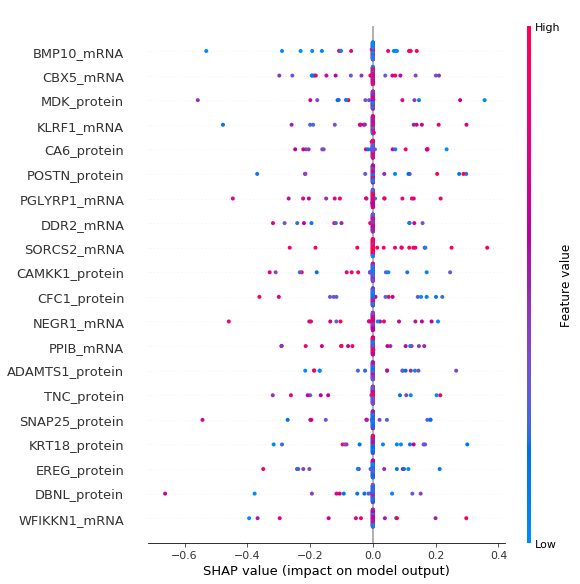

In [1113]:
#shap.summary_plot(shap_values, X_test_gnn, plot_type="bar", feature_names=feature_name)
shap.summary_plot(shap_values_test, X_test_gnn_ns, plot_type="dot", feature_names=updated_features) 

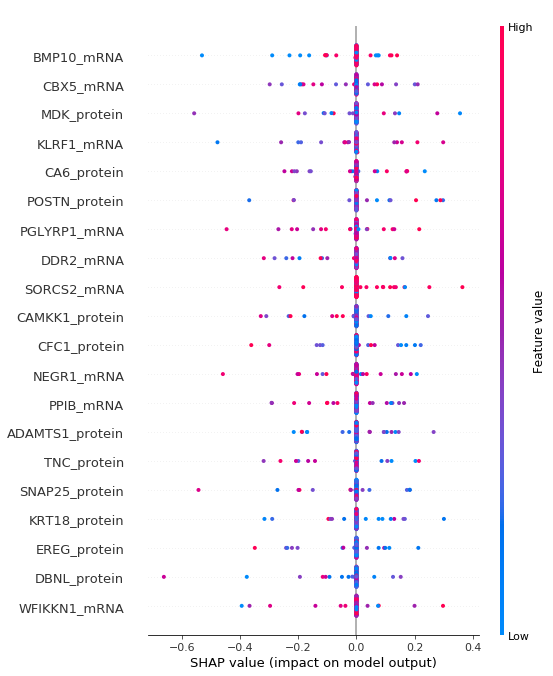

In [1165]:
import matplotlib.pyplot as plt
shapdot = shap.summary_plot(shap_values_test, X_test_gnn_ns, plot_type="dot", feature_names=updated_features,show=False) 
plt.tight_layout()
plt.savefig('shapdot.pdf', dpi=300, box_inchs='tight')

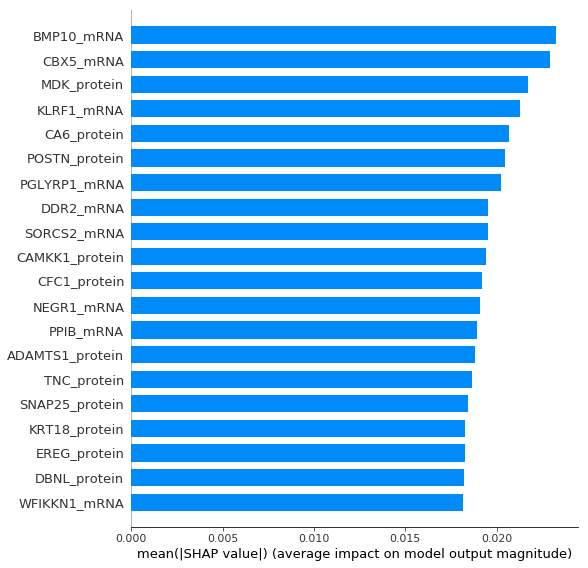

In [1116]:
#shap.summary_plot(shap_values, X_test_gnn, plot_type="bar", feature_names=feature_name)
shap.summary_plot(shap_values_test, X_test_gnn_ns, plot_type="bar", feature_names=updated_features) 

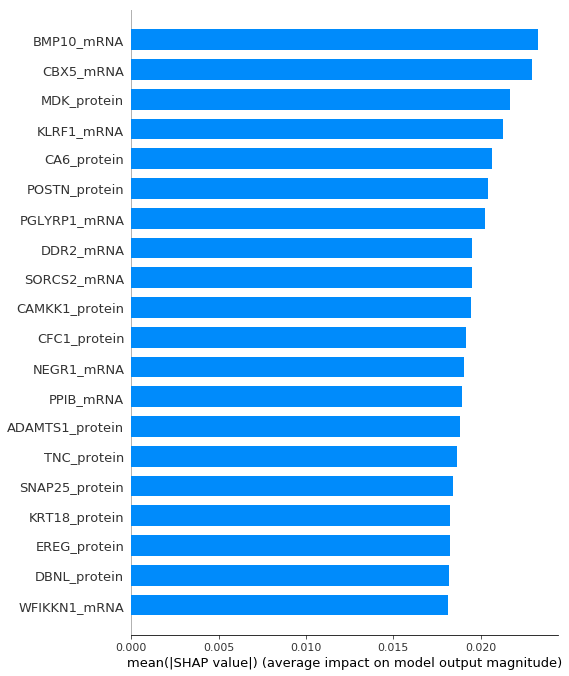

In [1166]:
shapBar = shap.summary_plot(shap_values_test, X_test_gnn_ns, plot_type="bar", feature_names=updated_features,show=False) 
plt.tight_layout()
plt.savefig('shapBar.pdf', dpi=300, box_inchs='tight')

In [1122]:
shap.initjs()
shap.force_plot(explainer_train.expected_value, shap_values_test[10,:], updated_features)

In [1480]:
print ("For subject: "+ test_sid[10])
print ("true diagnosis: " + str(y_test[10]) + " while the prediction is " + str(test_pred_ns[10]))

For subject: 12558P
true diagnosis: 0 while the prediction is 0.0


In [1129]:
shap.initjs()
shap.force_plot(explainer_train.expected_value, shap_values_test[5,:], updated_features)

In [1132]:
shap.initjs()
shap.force_plot(explainer_train.expected_value, shap_values_test[8,:], updated_features)

In [1440]:
shap.initjs()
shap.force_plot(explainer_train.expected_value, shap_values_test[16,:], updated_features)

In [1441]:
shap.initjs()
shap.force_plot(explainer_train.expected_value, shap_values_test[17,:], updated_features)